In [524]:
## IMPORT 

import os
import numpy as  np
import pylab as plt
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize
from scipy.signal import resample
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import h5py as h5
import h5py
from pathlib import Path
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simpson
from scipy.stats import pearsonr
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
## SMOOTHING
from scipy.signal import savgol_filter
from scipy.stats import ttest_ind

## figure settings

In [525]:
# Text   
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = '.SF Camera'

# Boxes
mpl.rcParams['axes.spines.top']= False
mpl.rcParams['axes.spines.right']= False

# plt.rcParams['figure.figsize'] = [4, 5]
plt.rcParams['figure.dpi'] = 140

## df management 

In [526]:
directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/EPM_FP/EPM_BLA/preprocessed/'

# Find all CSV files in the directory
csv_files = glob.glob(os.path.join(directory, "*.csv"))

# Initialize list to store df
df = pd.DataFrame()

# Loop through each CSV, then concatenate them into a single df
for file in csv_files:
    single = pd.read_csv(file)
    df = pd.concat([df, single], axis=0, ignore_index=True)

df

,Time,Zscoreg,Zscorer,Freezing,In Open Arms,In Closed Arms,In middle,ID,sex
0,0.089557,0.558512,0.101862,0,0,1,0,1029,M
1,0.106232,0.558512,0.101862,0,0,1,0,1029,M
2,0.122907,0.558512,0.101862,0,0,1,0,1029,M
3,0.139583,0.558512,0.101862,0,0,1,0,1029,M
4,0.156258,0.558512,0.101862,0,0,1,0,1029,M
...,...,...,...,...,...,...,...,...,...
423519,600.214558,0.863644,-0.736394,0,0,0,0,1045,F
423520,600.231229,0.838020,-0.148822,0,0,0,0,1045,F
423521,600.247901,0.812075,0.085983,0,0,0,0,1045,F
423522,600.264572,0.803870,-0.221569,0,0,0,0,1045,F


In [527]:
polyorder = 2  # Polynomial order
window_length = 61  # Window length: must be an odd number

# Group by ID and day, then apply the Savitzky-Golay filter
df['Zscoreg'] = df.groupby(['ID'])['Zscoreg'].transform(lambda x: savgol_filter(x, window_length, polyorder))

In [528]:
# df = df[df['ID'].isin([118, 116])].reset_index(drop=True)

## AUC 

              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   AUC_per_sec
No. Observations:     35        Method:               REML       
No. Groups:           12        Scale:                665.3270   
Min. group size:      2         Log-Likelihood:       -154.8621  
Max. group size:      3         Converged:            Yes        
Mean group size:      2.9                                        
-----------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept           -13.517    7.917 -1.707 0.088 -29.034   2.000
Condition[T.Middle]  57.798   10.530  5.489 0.000  37.159  78.437
Condition[T.Open]    93.315   10.843  8.606 0.000  72.064 114.567
Group Var            86.819    6.850                             

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lowe

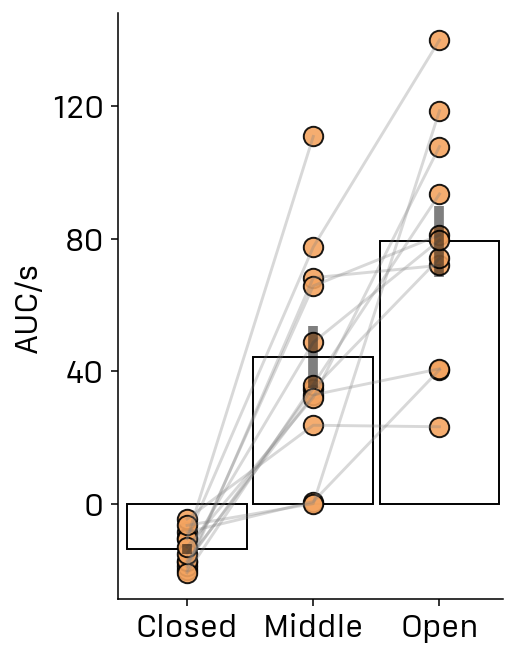

In [543]:
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def plot_auc_per_second_with_anova(df):
    # Lists to store the AUC per second for each condition (per mouse)
    mouse_auc_values = {'ID': [], 'Condition': [], 'AUC_per_sec': []}
    # df['Zscoreg'] = df.groupby('ID')['Zscoreg'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

    
    # Loop through each mouse
    for mouse in df['ID'].unique():
        # Filter the data for the current mouse
        mouse_data = df[df['ID'] == mouse]
        
        # For each compartment (condition), calculate AUC and time spent
        for condition, condition_column in zip(['Open', 'Middle', 'Closed'], 
                                                ['In Open Arms', 'In middle', 'In Closed Arms']):
            
            # Filter data where the mouse was in the current condition (column value = 1)
            condition_data = mouse_data[mouse_data[condition_column] == 1]
            
            # Calculate AUC for the condition by summing Zscoreg in the time the mouse was in this compartment
            auc = condition_data['Zscoreg'].sum()
            
            # Calculate time spent in the compartment (number of samples, converted to seconds)
            time_spent = len(condition_data) / 60  # Assuming 60 Hz sampling rate

        
        
            # AUC per second for the condition
            auc_per_sec = auc / time_spent
            if time_spent < 5:
                continue 
            # Append the values
            mouse_auc_values['ID'].append(mouse)
            mouse_auc_values['Condition'].append(condition)
            mouse_auc_values['AUC_per_sec'].append(auc_per_sec)
    
    # Convert to DataFrame
    auc_per_sec_df = pd.DataFrame(mouse_auc_values)


    # Reset index to ensure proper alignment
    auc_per_sec_df = auc_per_sec_df.reset_index(drop=True)

    model = mixedlm("AUC_per_sec ~ Condition", auc_per_sec_df, groups=auc_per_sec_df["ID"])
    mixedlm_results = model.fit()
    print(mixedlm_results.summary())

    
    # Perform post-hoc pairwise comparisons using Tukey's HSD
    tukey = pairwise_tukeyhsd(auc_per_sec_df['AUC_per_sec'], auc_per_sec_df['Condition'])
    print(tukey)
    
    # Plot the AUC per second for each mouse (individual values)
    plt.figure(figsize=(4,5))

   
        
    for condition in ['Closed', 'Middle', 'Open']:
        # Plot the individual AUC per second for each mouse
        plt.scatter(
            np.repeat(condition, len(auc_per_sec_df[auc_per_sec_df['Condition'] == condition])), 
            auc_per_sec_df[auc_per_sec_df['Condition'] == condition]['AUC_per_sec'], 
            alpha=0.9, color='sandybrown',edgecolor='black', s=100
        )

        # Add lines connecting individual data points by ID
    for mouse in auc_per_sec_df['ID'].unique():
        mouse_data = auc_per_sec_df[auc_per_sec_df['ID'] == mouse]
        plt.plot(mouse_data['Condition'], mouse_data['AUC_per_sec'], color='grey', alpha=0.3)

    
    # Calculate means and SEM
    means = auc_per_sec_df.groupby('Condition')['AUC_per_sec'].mean()
    print(means)
    sems = auc_per_sec_df.groupby('Condition')['AUC_per_sec'].sem()
    
    plt.bar(means.index, means, yerr=sems, capsize=0, color='none', alpha=1, edgecolor='black', 
            label='Mean AUC per second', width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
    
    # Add labels and title

    plt.ylabel('AUC/s')
    ax = plt.gca()  # Get the current axis
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 5
    ax.set_xlim(-0.55,3-0.5)
    
    # Show the plot

    plt.tight_layout()
    #plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/EPM_FP/EPM_BLA/figures/aucs.pdf', format='pdf')
    plt.show()

    return mixedlm_results, tukey

# Example usage:
# Call the function to calculate and plot AUC per second for each condition, perform ANOVA, and Tukey's post-hoc
mixedlm_results, tukey_results = plot_auc_per_second_with_anova(df)

      ID Condition  AUC_per_sec sex
0   1029      Open    40.474086   M
1   1029    Middle     0.747922   M
2   1029    Closed    -8.447025   M
3   1034      Open    71.928004   M
4   1034    Middle    68.197983   M
5   1034    Closed   -19.997547   M
6    129    Middle   110.769909   F
7    129    Closed   -10.332559   F
8   1051      Open    74.045179   F
9   1051    Middle    34.807355   F
10  1051    Closed   -17.567091   F
11  1052      Open   139.826521   F
12  1052    Middle    77.458968   F
13  1052    Closed   -10.443597   F
14   116      Open    81.074118   M
15   116    Middle    65.751565   M
16   116    Closed   -18.773632   M
17  1050      Open    40.745961   F
18  1050    Middle    32.894567   F
19  1050    Closed   -17.056205   F
20   118      Open    23.296878   M
21   118    Middle    23.754381   M
22   118    Closed    -4.479007   M
23  1035      Open    93.428722   M
24  1035    Middle    36.028012   M
25  1035    Closed   -20.694257   M
26  1028      Open   118.503

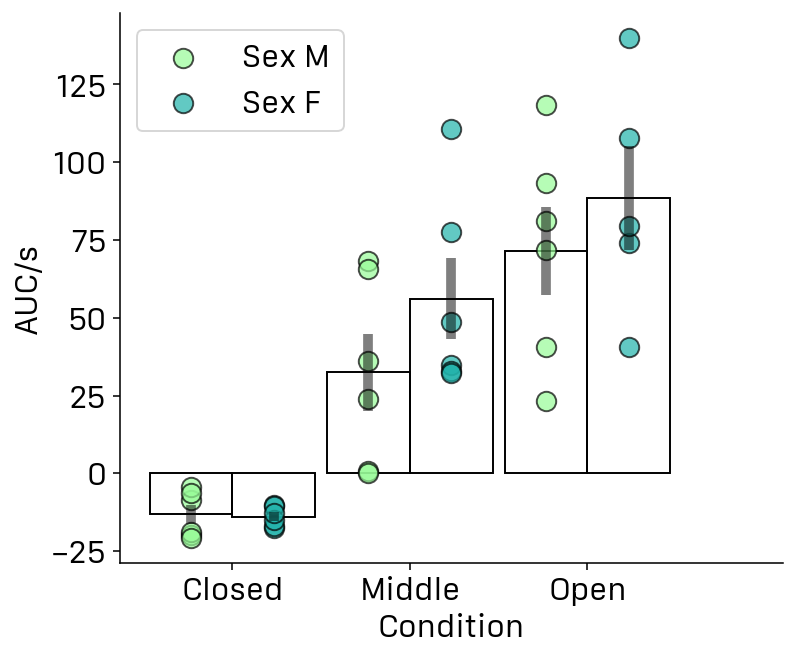

In [556]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib.ticker import MaxNLocator

def auc_per_second_with_mixedlm_per_sex(df):
    # Lists to store the AUC per second for each condition (per mouse)
    mouse_auc_values = {'ID': [], 'Condition': [], 'AUC_per_sec': [], 'sex': []}
    
    # Loop through each mouse
    for mouse in df['ID'].unique():
        # Filter the data for the current mouse
        mouse_data = df[df['ID'] == mouse]
        
        # For each compartment (condition), calculate AUC and time spent
        for condition, condition_column in zip(['Open', 'Middle', 'Closed'], 
                                                ['In Open Arms', 'In middle', 'In Closed Arms']):
            
            # Filter data where the mouse was in the current condition (column value = 1)
            condition_data = mouse_data[mouse_data[condition_column] == 1]
            
            # Calculate time spent in the compartment (number of samples, converted to seconds)
            time_spent = len(condition_data) / 60  # Assuming 60 Hz sampling rate
            
            # Skip conditions where time spent is less than 10 seconds
            if time_spent < 10:
                continue
            
            # Calculate AUC for the condition by summing Zscoreg in the time the mouse was in this compartment
            auc = condition_data['Zscoreg'].sum()
            
            # AUC per second for the condition
            auc_per_sec = auc / time_spent
            
            # Append the values
            mouse_auc_values['ID'].append(mouse)
            mouse_auc_values['Condition'].append(condition)
            mouse_auc_values['AUC_per_sec'].append(auc_per_sec)
            mouse_auc_values['sex'].append(mouse_data['sex'].iloc[0])
    
    # Convert to DataFrame
    auc_per_sec_df = pd.DataFrame(mouse_auc_values)
    print(auc_per_sec_df)
    
    # Perform a mixed-effects model analysis
    model = mixedlm("AUC_per_sec ~ Condition * sex", auc_per_sec_df, groups=auc_per_sec_df["ID"])
    mixedlm_results = model.fit()
    print(mixedlm_results.summary())
    
    # Perform post-hoc pairwise comparisons using Tukey's HSD
    tukey = pairwise_tukeyhsd(auc_per_sec_df['AUC_per_sec'], auc_per_sec_df['Condition'] + auc_per_sec_df['sex'])
    print(tukey)
    
    # Plot the AUC per second for each mouse (individual values)
    plt.figure(figsize=(6, 5))

    conditions = ['Closed', 'Middle', 'Open']
    sexes = ['M', 'F']
    bar_width = 0.35
    index = np.arange(len(conditions)) * (0.4 + bar_width)  # Adjust spacing between bars

    for i, sex in enumerate(sexes):
        means = auc_per_sec_df[auc_per_sec_df['sex'] == sex].groupby('Condition')['AUC_per_sec'].mean()
        sems = auc_per_sec_df[auc_per_sec_df['sex'] == sex].groupby('Condition')['AUC_per_sec'].sem()
        plt.bar(index + i * bar_width, means, bar_width, yerr=sems, capsize=0, error_kw=dict(lw=5, alpha=0.5, zorder=4), 
                edgecolor='black', color='none')

    # Add individual data points
    for i, sex in enumerate(sexes):
        for condition in conditions:
            condition_data = auc_per_sec_df[(auc_per_sec_df['Condition'] == condition) & (auc_per_sec_df['sex'] == sex)]
            color = 'palegreen' if sex == 'M' else 'lightseagreen'
            plt.scatter(np.repeat(index[conditions.index(condition)] + i * bar_width, len(condition_data)), 
                        condition_data['AUC_per_sec'], alpha=0.7, edgecolor='black', s=100, color=color, label=f'Sex {sex}' if condition == 'Open' else "")

    plt.xlabel('Condition')
    plt.ylabel('AUC/s')
    plt.xticks(index + bar_width / 2, conditions)
    plt.legend()
    plt.xlim((-0.3,3-0.5))
    plt.tight_layout()

    # Show the plot
    #plt.savefig(f'/Users/ossamaghenissa/Desktop/anxietypaper/figures/sexdifferences/EPMAUC.pdf', format='pdf')
    plt.show()

    return auc_per_sec_df, mixedlm_results, tukey

# Example usage:
# Call the function to calculate and plot AUC per second for each condition, perform mixed-effects model analysis, and Tukey's post-hoc
auc_per_sec_df, mixedlm_results, tukey_results = auc_per_second_with_mixedlm_per_sex(df)

/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood o

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Q('Peak Average')
No. Observations: 35      Method:             REML             
No. Groups:       12      Scale:              0.7418           
Min. group size:  2       Log-Likelihood:     -44.3381         
Max. group size:  3       Converged:          No               
Mean group size:  2.9                                          
---------------------------------------------------------------
                       Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept              1.337    0.249 5.373 0.000  0.849  1.825
Condition[T.Middle]    0.472    0.352 1.342 0.180 -0.217  1.161
Condition[T.Open Arms] 1.440    0.362 3.984 0.000  0.732  2.149
Group Var              0.001    0.223                          

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1     group2  meandiff p-adj   lower  upper  rej

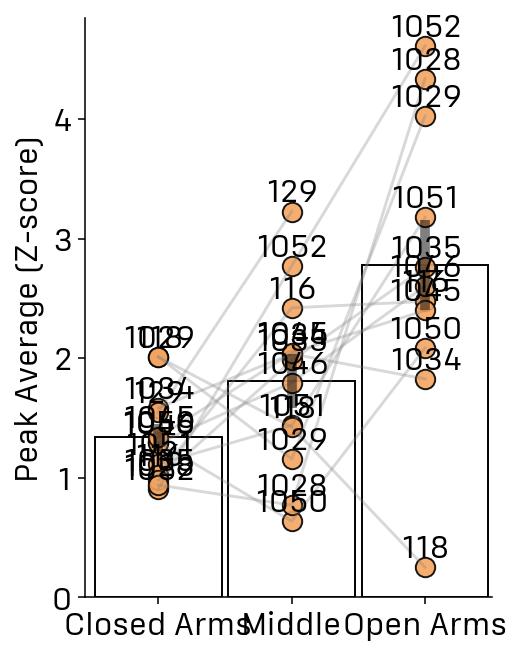

In [530]:
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_peak_average_with_anova(df):
    # Lists to store peak averages for each condition (per mouse)
    mouse_peak_values = {'ID': [], 'Condition': [], 'Peak Average': []}

    # Loop through each mouse
    for mouse in df['ID'].unique():
        # Filter the data for the current mouse
        mouse_data = df[df['ID'] == mouse].reset_index(drop=True)
        
        # For each compartment (condition), calculate peak averages
        for condition, condition_column in zip(['Open Arms', 'Middle', 'Closed Arms'], 
                                                ['In Open Arms', 'In middle', 'In Closed Arms']):
            
            # Identify bouts where the condition transitions from 0 to 1 and back to 0
            condition_data = mouse_data[condition_column]
            start_indices = condition_data[(condition_data.shift() == 0) & (condition_data == 1)].index
            end_indices = condition_data[(condition_data.shift() == 1) & (condition_data == 0)].index
            
            # Handle cases where recording starts with 1
            if condition_data.iloc[0] == 1:
                start_indices = start_indices.insert(0, 0)
            
            # Handle cases where recording ends with 1
            if condition_data.iloc[-1] == 1:
                end_indices = end_indices.append(pd.Index([len(condition_data) - 1]))
            
            bout_peaks = []

            for start, end in zip(start_indices, end_indices):
                if end - start < 300:  ### 5 seconds
                    continue
                indpeak = mouse_data.loc[start:end, 'Zscoreg'].max()
                bout_peaks.append(indpeak)
            
            # Compute the average peak for the condition
            if bout_peaks:
                peak_average = np.mean(bout_peaks)
                mouse_peak_values['ID'].append(mouse)
                mouse_peak_values['Condition'].append(condition)
                mouse_peak_values['Peak Average'].append(peak_average)

    # Convert to DataFrame
    peak_avg_df = pd.DataFrame(mouse_peak_values)

    # Reset index to ensure proper alignment
    peak_avg_df = peak_avg_df.reset_index(drop=True)

    # Perform mixed effects linear model
    model = mixedlm("Q('Peak Average') ~ Condition", peak_avg_df, groups=peak_avg_df["ID"])
    mixedlm_results = model.fit()
    print(mixedlm_results.summary())

    # Perform post-hoc pairwise comparisons using Tukey's HSD
    tukey = pairwise_tukeyhsd(peak_avg_df['Peak Average'], peak_avg_df['Condition'])
    print(tukey)

    # Plot the peak averages for each mouse (individual values)
    plt.figure(figsize=(4, 5))

    for condition in ['Closed Arms', 'Middle', 'Open Arms']:
        # Plot individual peak averages for each mouse
        condition_data = peak_avg_df[peak_avg_df['Condition'] == condition]
        plt.scatter(
            np.repeat(condition, len(condition_data)), 
            condition_data['Peak Average'], 
            alpha=0.9, color='sandybrown', edgecolor='black', s=100
        )
        # Annotate each point with the mouse ID
        for i, row in condition_data.iterrows():
            plt.annotate(row['ID'], (condition, row['Peak Average']), textcoords="offset points", xytext=(0,5), ha='center')

    # Add lines connecting individual data points by ID
    for mouse in peak_avg_df['ID'].unique():
        mouse_data = peak_avg_df[peak_avg_df['ID'] == mouse]
        plt.plot(mouse_data['Condition'], mouse_data['Peak Average'], color='grey', alpha=0.3)

    # Calculate means and SEM
    means = peak_avg_df.groupby('Condition')['Peak Average'].mean()
    sems = peak_avg_df.groupby('Condition')['Peak Average'].sem()

    plt.bar(means.index, means, yerr=sems, capsize=0, color='none', alpha=1, edgecolor='black', 
            label='Mean Peak Average', width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)

    # Add labels and title
    plt.ylabel('Peak Average (Z-score)')
    ax = plt.gca()
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.set_xlim(-0.55, 2.5)

    # Show the plot
    plt.tight_layout()
    plt.show()

    return mixedlm_results, tukey

# Example usage:
# Call the function to calculate and plot peak averages for each condition, perform ANOVA, and Tukey's post-hoc
mixedlm_results, tukey_results = plot_peak_average_with_anova(df)



## Behavior

/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood o

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     time_spent
No. Observations:      35          Method:                 REML      
No. Groups:            12          Scale:                  1508.0154 
Min. group size:       2           Log-Likelihood:         -166.3912 
Max. group size:       3           Converged:              No        
Mean group size:       2.9                                           
---------------------------------------------------------------------
                     Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
---------------------------------------------------------------------
Intercept            460.721   11.283  40.833 0.000  438.607  482.835
Condition[T.Middle] -369.474   15.854 -23.305 0.000 -400.546 -338.401
Condition[T.Open]   -421.746   16.201 -26.032 0.000 -453.499 -389.993
Group Var             19.639                                         

   Multiple Comparison of Means - T

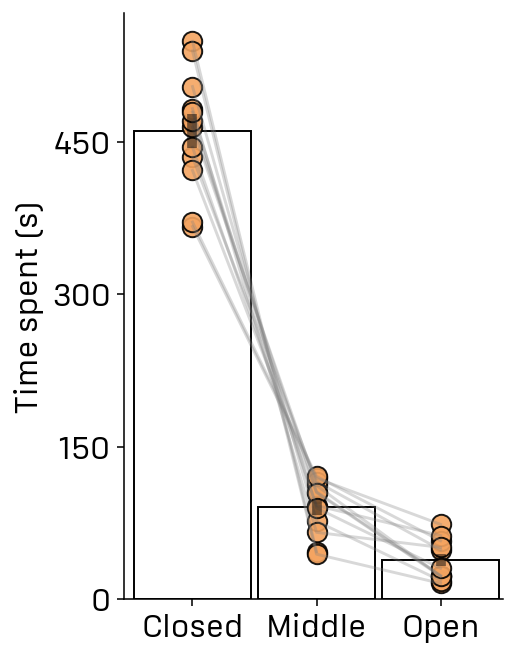

In [558]:
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def plot_time_spent(df):
    # Lists to store the AUC per second for each condition (per mouse)
    mouse_auc_values = {'ID': [], 'Condition': [], 'time_spent': []}
    # df['Zscoreg'] = df.groupby('ID')['Zscoreg'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

    
    # Loop through each mouse
    for mouse in df['ID'].unique():
        # Filter the data for the current mouse
        mouse_data = df[df['ID'] == mouse]
        
        # For each compartment (condition), calculate AUC and time spent
        for condition, condition_column in zip(['Open', 'Middle', 'Closed'], 
                                                ['In Open Arms', 'In middle', 'In Closed Arms']):
            
            # Filter data where the mouse was in the current condition (column value = 1)
            condition_data = mouse_data[mouse_data[condition_column] == 1]
            
            
            # Calculate time spent in the compartment (number of samples, converted to seconds)
            time_spent = len(condition_data) / 60  # Assuming 60 Hz sampling rate

            if time_spent < 5:
                continue 
            # Append the values
            mouse_auc_values['ID'].append(mouse)
            mouse_auc_values['Condition'].append(condition)
            mouse_auc_values['time_spent'].append(time_spent)
    
    # Convert to DataFrame
    auc_per_sec_df = pd.DataFrame(mouse_auc_values)


    # Reset index to ensure proper alignment
    auc_per_sec_df = auc_per_sec_df.reset_index(drop=True)

    model = mixedlm("time_spent ~ Condition", auc_per_sec_df, groups=auc_per_sec_df["ID"])
    mixedlm_results = model.fit()
    print(mixedlm_results.summary())

    
    # Perform post-hoc pairwise comparisons using Tukey's HSD
    tukey = pairwise_tukeyhsd(auc_per_sec_df['time_spent'], auc_per_sec_df['Condition'])
    print(tukey)
    
    # Plot the AUC per second for each mouse (individual values)
    plt.figure(figsize=(4,5))

   
        
    for condition in ['Closed', 'Middle', 'Open']:
        # Plot the individual AUC per second for each mouse
        plt.scatter(
            np.repeat(condition, len(auc_per_sec_df[auc_per_sec_df['Condition'] == condition])), 
            auc_per_sec_df[auc_per_sec_df['Condition'] == condition]['time_spent'], 
            alpha=0.9, color='sandybrown',edgecolor='black', s=100
        )

        # Add lines connecting individual data points by ID
    for mouse in auc_per_sec_df['ID'].unique():
        mouse_data = auc_per_sec_df[auc_per_sec_df['ID'] == mouse]
        plt.plot(mouse_data['Condition'], mouse_data['time_spent'], color='grey', alpha=0.3)

    
    # Calculate means and SEM
    means = auc_per_sec_df.groupby('Condition')['time_spent'].mean()
    sems = auc_per_sec_df.groupby('Condition')['time_spent'].sem()
    
    plt.bar(means.index, means, yerr=sems, capsize=0, color='none', alpha=1, edgecolor='black', 
            label='Mean AUC per second', width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
    
    # Add labels and title

    plt.ylabel('Time spent (s)')
    ax = plt.gca()  # Get the current axis
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 5
    ax.set_xlim(-0.55,3-0.5)
    
    # Show the plot

    plt.tight_layout()
    #plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/EPM_FP/EPM_BLA/figures/behavior.pdf', format='pdf')
    plt.show()

    return mixedlm_results, tukey

# Example usage:
# Call the function to calculate and plot AUC per second for each condition, perform ANOVA, and Tukey's post-hoc
mixedlm_results, tukey_results = plot_time_spent(df)

/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        time_spent
No. Observations:         36             Method:                    REML      
No. Groups:               12             Scale:                     1509.4420 
Min. group size:          3              Log-Likelihood:            -157.7384 
Max. group size:          3              Converged:                 Yes       
Mean group size:          3.0                                                 
------------------------------------------------------------------------------
                              Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------------------
Intercept                     476.033   15.862  30.010 0.000  444.944  507.123
Condition[T.Middle]          -395.392   22.431 -17.627 0.000 -439.356 -351.428
Condition[T.Open]            -441.403   22.431 -19.678 0.000 -485.367 -39

trak NOT subset; don't know how to subset; dropped


    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1  group2  meandiff p-adj    lower     upper   reject
-----------------------------------------------------------
ClosedF ClosedM   -30.625 0.7466  -98.8515   37.6015  False
ClosedF MiddleF -395.3917    0.0 -463.6181 -327.1652   True
ClosedF MiddleM -374.1806    0.0  -442.407 -305.9541   True
ClosedF   OpenF -441.4028    0.0 -509.6292 -373.1763   True
ClosedF   OpenM -438.6583    0.0 -506.8848 -370.4319   True
ClosedM MiddleF -364.7667    0.0 -432.9931 -296.5402   True
ClosedM MiddleM -343.5556    0.0  -411.782 -275.3291   True
ClosedM   OpenF -410.7778    0.0 -479.0042 -342.5513   True
ClosedM   OpenM -408.0333    0.0 -476.2598 -339.8069   True
MiddleF MiddleM   21.2111 0.9311  -47.0154   89.4376  False
MiddleF   OpenF  -46.0111 0.3389 -114.2376   22.2154  False
MiddleF   OpenM  -43.2667 0.4052 -111.4931   24.9598  False
MiddleM   OpenF  -67.2222 0.0553 -135.4487    1.0042  False
MiddleM   OpenM  -64.4778 0.0725 -132.70

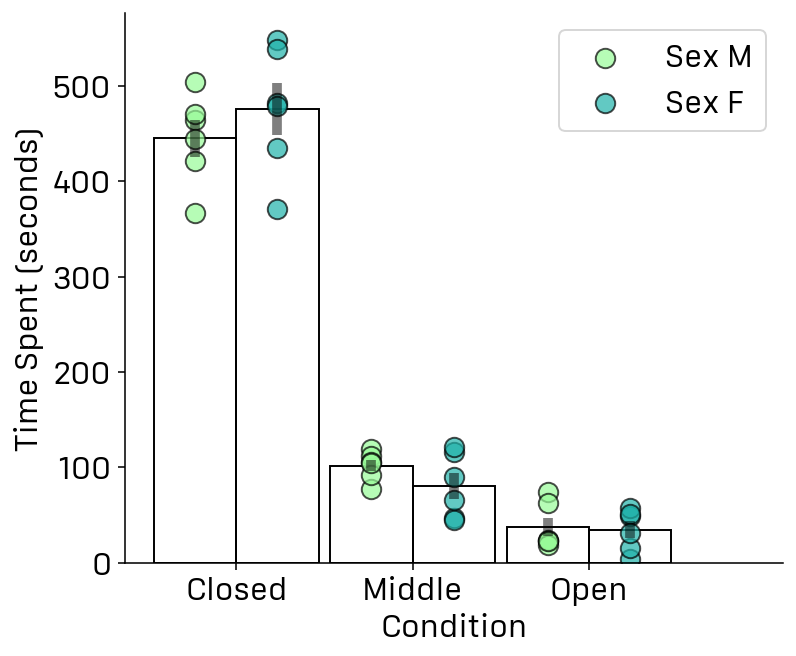

In [563]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib.ticker import MaxNLocator

def plot_time_spent_in_compartments(df):
    # Dictionary to store individual time spent values for each mouse (for plotting)
    mouse_time_values = {'ID': [], 'Condition': [], 'time_spent': [], 'sex': []}
    
    # Loop through each mouse
    for mouse in df['ID'].unique():
        # Filter the data for the current mouse
        mouse_data = df[df['ID'] == mouse]
        
        # For each compartment (condition), calculate the time spent in seconds
        for condition, condition_column in zip(['Open', 'Middle', 'Closed'], 
                                                ['In Open Arms', 'In middle', 'In Closed Arms']):
            
            # Filter data where the mouse was in the current condition (column value = 1)
            condition_data = mouse_data[mouse_data[condition_column] == 1]
            
            if len(condition_data) == 0:
                # If no time spent in this condition, append 0 for time spent
                time_spent = 0
            else:
                # Calculate the time spent in the condition (in seconds)
                time_spent = len(condition_data) / 60 # Assuming 60 Hz sampling rate
                
            # Append the time spent for each condition to the corresponding list
            mouse_time_values['ID'].append(mouse)
            mouse_time_values['Condition'].append(condition)
            mouse_time_values['time_spent'].append(time_spent)
            mouse_time_values['sex'].append(mouse_data['sex'].iloc[0])

    time_spent_df = pd.DataFrame(mouse_time_values)

    # STATS
    model = mixedlm("time_spent ~ Condition * sex", time_spent_df, groups=time_spent_df["ID"])
    mixedlm_results = model.fit()
    print(mixedlm_results.summary())

    tukey = pairwise_tukeyhsd(time_spent_df['time_spent'], time_spent_df['Condition'] + time_spent_df['sex'])
    print(tukey)
    
    # PLOTTING
    plt.figure(figsize=(6, 5))

    conditions = ['Closed', 'Middle', 'Open']
    sexes = ['M', 'F']
    bar_width = 0.35
    index = np.arange(len(conditions)) * (0.4 + bar_width)  # Adjust spacing between bars

    for i, sex in enumerate(sexes):
        means = time_spent_df[time_spent_df['sex'] == sex].groupby('Condition')['time_spent'].mean()
        sems = time_spent_df[time_spent_df['sex'] == sex].groupby('Condition')['time_spent'].sem()
        plt.bar(index + i * bar_width, means, bar_width, yerr=sems, capsize=0, error_kw=dict(lw=5, alpha=0.5, zorder=4), 
                edgecolor='black', color='none')

    # Add individual data points
    for i, sex in enumerate(sexes):
        for condition in conditions:
            condition_data = time_spent_df[(time_spent_df['Condition'] == condition) & (time_spent_df['sex'] == sex)]
            color = 'palegreen' if sex == 'M' else 'lightseagreen'
            plt.scatter(np.repeat(index[conditions.index(condition)] + i * bar_width, len(condition_data)), 
                        condition_data['time_spent'], alpha=0.7, edgecolor='black', s=100, color=color, label=f'Sex {sex}' if condition == 'Open' else "")

    plt.xlabel('Condition')
    plt.ylabel('Time Spent (seconds)')
    plt.xticks(index + bar_width / 2, conditions)
    plt.legend()
    plt.xlim((-0.3, 3 - 0.5))
    plt.tight_layout()

    # Show the plot
    # plt.savefig(f'/Users/ossamaghenissa/Desktop/anxietypaper/figures/sexdifferences/EPMbehavior.pdf', format='pdf')
    plt.show()

    return time_spent_df

# Example usage:
# Call the function to calculate and plot time spent in each compartment for each mouse
time_spent_df = plot_time_spent_in_compartments(df)


## SORTING

In [532]:
#NEW OPEN TO CLOSED 
# Parameters
sampling_rate = 60
min_closedarms_rows = 5 * sampling_rate  # Convert time to rows
min_after_rows = 10 * sampling_rate      # Convert time to rows

# Initialize list to store processed mouse data
processed_mouse_data = []

for mouse in df['ID'].unique():
    # Filter the data for the current mouse
    mouse_data = df[df['ID'] == mouse].reset_index(drop=True)
    
    # Create a boolean mask where 'In Closed Arms' is 1 for the current mouse
    closed_arms_mask = mouse_data['In Closed Arms'] == 1
    
    # Identify indices where 'In Closed Arms' transitions from 1 to 0
    transition_indices = closed_arms_mask[(closed_arms_mask.shift(1) == 0) & (closed_arms_mask == 1)].index

    # Iterate through transition indices
    for transition_index in transition_indices:
        # Define start and end indices for checks
        preceding_start_index = max(0, transition_index - min_closedarms_rows)
        following_end_index = min(len(mouse_data), transition_index + min_after_rows)
        
        # Get preceding and following rows
        preceding_rows = mouse_data.loc[preceding_start_index:transition_index - 1, 'In Closed Arms']
        following_rows = mouse_data.loc[transition_index:following_end_index - 1, 'In Closed Arms']
        
        # Check if conditions are satisfied
        if preceding_rows.eq(0).mean() >= 0.8 and following_rows.eq(1).mean() >= 0.8:  #rule so that 80% of rows must met the condition
            mouse_data.loc[transition_index, 'valid_transition'] = 1
        else:
            print(f"Transition at index {transition_index} for mouse {mouse} skipped due to unmet conditions.")
    
    # Append the processed mouse data to the list
    processed_mouse_data.append(mouse_data)

# Concatenate all processed mouse data into a single DataFrame
df = pd.concat(processed_mouse_data, ignore_index=True)

# Display results
print(df['valid_transition'].value_counts())

Transition at index 746 for mouse 1029 skipped due to unmet conditions.
Transition at index 814 for mouse 1029 skipped due to unmet conditions.
Transition at index 1735 for mouse 1029 skipped due to unmet conditions.
Transition at index 1958 for mouse 1029 skipped due to unmet conditions.
Transition at index 4498 for mouse 1029 skipped due to unmet conditions.
Transition at index 7701 for mouse 1029 skipped due to unmet conditions.
Transition at index 8631 for mouse 1029 skipped due to unmet conditions.
Transition at index 8699 for mouse 1029 skipped due to unmet conditions.
Transition at index 10629 for mouse 1029 skipped due to unmet conditions.
Transition at index 11979 for mouse 1029 skipped due to unmet conditions.
Transition at index 12936 for mouse 1029 skipped due to unmet conditions.
Transition at index 12943 for mouse 1029 skipped due to unmet conditions.
Transition at index 12967 for mouse 1029 skipped due to unmet conditions.
Transition at index 13013 for mouse 1029 skipped

In [533]:
# # NEW CLOSED TO OPEN 
# # Parameters
# sampling_rate = 60
# min_closedarms_rows = 5 * sampling_rate  # Convert time to rows
# min_after_rows = 10 * sampling_rate      # Convert time to rows

# # Initialize list to store processed mouse data
# processed_mouse_data = []

# for mouse in df['ID'].unique():
#     # Filter the data for the current mouse
#     mouse_data = df[df['ID'] == mouse].reset_index(drop=True)
    
#     # Create a boolean mask where 'In Closed Arms' is 1 for the current mouse
#     closed_arms_mask = mouse_data['In Closed Arms'] == 1
    
#     # Identify indices where 'In Closed Arms' transitions from 1 to 0
#     transition_indices = closed_arms_mask[(closed_arms_mask.shift(1) == 1) & (closed_arms_mask == 0)].index

#     # Iterate through transition indices
#     for transition_index in transition_indices:
#         # Define start and end indices for checks
#         preceding_start_index = max(0, transition_index - min_closedarms_rows)
#         following_end_index = min(len(mouse_data), transition_index + min_after_rows)
        
#         # Get preceding and following rows
#         preceding_rows = mouse_data.loc[preceding_start_index:transition_index - 1, 'In Closed Arms']
#         following_rows = mouse_data.loc[transition_index:following_end_index - 1, 'In Closed Arms']
        
#         # Check if conditions are satisfied
#         if preceding_rows.eq(1).mean() >= 1 and following_rows.eq(0).mean() >= 1:  #rule so that 80% of rows must met the condition
#             mouse_data.loc[transition_index, 'valid_transition'] = 1
#         else:
#             print(f"Transition at index {transition_index} for mouse {mouse} skipped due to unmet conditions.")
    
#     # Append the processed mouse data to the list
#     processed_mouse_data.append(mouse_data)

# # Concatenate all processed mouse data into a single DataFrame
# df = pd.concat(processed_mouse_data, ignore_index=True)

# # Display results
# print(df['valid_transition'].value_counts())


In [534]:

# # OPEN ARMS SCRIPT
# sampling_rate=60
# min_closedarms_rows = 3 * sampling_rate
# min_after_rows = 5 * sampling_rate

# # Create a boolean mask where 'In Closed Arms' is 1
# closed_arms_mask = df['In Open Arms'] == 1

# # Identify indices where 'In Closed Arms' transitions from 1 to 0
# transition_indices = closed_arms_mask[(closed_arms_mask.shift(1) == 0) & (closed_arms_mask == 1)].index

# # Create a new column to mark valid transitions
# df['valid_transition'] = 0  # Default value is 0

# # Loop through each transition point
# for transition_index in transition_indices:
#     # Check the preceding rows for 'In Closed Arms = 1'
#     preceding_start_index = max(0, transition_index - min_closedarms_rows)
#     preceding_rows = df.iloc[preceding_start_index:transition_index]
    
#     if (preceding_rows['In Open Arms'] == 0).all():
#         # Check the following rows for 'In Closed Arms = 0'
#         following_end_index = min(len(df), transition_index + min_after_rows)
#         following_rows = df.iloc[transition_index:following_end_index]
        
#         if (following_rows['In Open Arms'] == 1).all():
#             # Mark the transition as valid
#             df.loc[transition_index, 'valid_transition'] = 1

# # Display the updated DataFrame and unique values of 'valid_transition'
# print(df)
# print(df['valid_transition'].unique())


## analysis

In [535]:
# Pre-tone and post-tone window settings
pre_tone = -5
post_tone = 10
sampling_freq = 60

presample = int(abs(pre_tone * sampling_freq))  # Number of samples before the tone
postsample = int(abs(post_tone * sampling_freq))  # Number of samples after the tone

total_samples = presample + postsample + 1  # Total samples from -3 to 5 seconds

# Create empty list to store processed dataframes
processed_dfs = []

# Iterate through each mouse
for mouse in df['ID'].unique():
    # Filter for the current mouse
    mousedf = df[df['ID'] == mouse].reset_index(drop=True)

    # Identify onset indices of valid transitions
    onset_indices = mousedf[mousedf['valid_transition'] == 1].index

    # Loop through each valid transition
    for t, onset in enumerate(onset_indices):
        # Define start and end indices for the time vector
        start_idx = onset - presample
        end_idx = onset + postsample

        # Ensure indices stay within bounds and length matches total_samples
        if start_idx >= 0 and end_idx < len(mousedf) and (end_idx - start_idx + 1) == total_samples:
            # Generate the time vector
            time_vector = np.linspace(pre_tone, post_tone, total_samples)

            # Assign the time vector and exploration number
            mousedf.loc[start_idx:end_idx, 'time_vector'] = time_vector
            mousedf.loc[start_idx:end_idx, 'exploration'] = 1
            mousedf.loc[start_idx:end_idx, 'explorationnumber'] = t + 1  # Start from 1
            print(f'ok {t + 1} for mouse {mouse}')
        else:
            print(f"Transition {t + 1} for mouse {mouse} skipped due to boundary conditions.")

    # Append the processed mouse DataFrame to the list
    processed_dfs.append(mousedf)

# Concatenate all processed DataFrames
df = pd.concat(processed_dfs, ignore_index=True)

# Display the updated DataFrame
print(df['explorationnumber'].unique())

ok 1 for mouse 1029
ok 2 for mouse 1029
ok 3 for mouse 1029
ok 4 for mouse 1029
ok 5 for mouse 1029
ok 6 for mouse 1029
ok 7 for mouse 1029
ok 8 for mouse 1029
ok 9 for mouse 1029
ok 10 for mouse 1029
ok 11 for mouse 1029
ok 12 for mouse 1029
ok 13 for mouse 1029
ok 14 for mouse 1029
ok 15 for mouse 1029
ok 1 for mouse 1034
ok 2 for mouse 1034
ok 3 for mouse 1034
ok 4 for mouse 1034
ok 5 for mouse 1034
ok 6 for mouse 1034
ok 7 for mouse 1034
ok 8 for mouse 1034
ok 9 for mouse 1034
ok 10 for mouse 1034
Transition 11 for mouse 1034 skipped due to boundary conditions.
ok 1 for mouse 129
ok 2 for mouse 129
ok 3 for mouse 129
ok 4 for mouse 129
ok 1 for mouse 1051
ok 2 for mouse 1051
ok 3 for mouse 1051
ok 4 for mouse 1051
ok 5 for mouse 1051
ok 6 for mouse 1051
ok 7 for mouse 1051
ok 8 for mouse 1051
ok 9 for mouse 1051
ok 10 for mouse 1051
ok 11 for mouse 1051
ok 12 for mouse 1051
Transition 13 for mouse 1051 skipped due to boundary conditions.
Transition 1 for mouse 1052 skipped due to b

In [536]:
# # Pre-tone and post-tone window settings
# pre_tone = -5
# post_tone = 10
# sampling_freq = 60

# presample = int(abs(pre_tone * sampling_freq))  # Number of samples before the tone
# postsample = int(abs(post_tone * sampling_freq))  # Number of samples after the tone

# total_samples = presample + postsample + 1  # Total samples from -3 to 5 seconds

# # Create empty list to store processed dataframes
# processed_dfs = []

# # Iterate through each mouse
# for mouse in df['ID'].unique():
#     # Filter for the current mouse
#     mousedf = df[df['ID'] == mouse].reset_index(drop=True)

#     # Identify onset indices of valid transitions
#     onset_indices = mousedf[mousedf['valid_transition'] == 1].index

#     # Loop through each valid transition
#     for t, onset in enumerate(onset_indices):
#         # Define start and end indices for the time vector
#         start_idx = onset - presample
#         end_idx = onset + postsample

#         # Ensure indices stay within bounds and length matches total_samples
#         if start_idx >= 0 and end_idx < len(mousedf) and (end_idx - start_idx + 1) == total_samples:
#             # Generate the time vector
#             time_vector = np.linspace(pre_tone, post_tone, total_samples)

#             # Assign the time vector and exploration number
#             mousedf.loc[start_idx:end_idx, 'time_vector'] = time_vector
#             mousedf.loc[start_idx:end_idx, 'exploration'] = 1
#             mousedf.loc[start_idx:end_idx, 'explorationnumber'] = t + 1  # Start from 1
#             print(f'ok {t + 1} for mouse {mouse}')
#         else:
#             print(f"Transition {t + 1} for mouse {mouse} skipped due to boundary conditions.")

#     # Append the processed mouse DataFrame to the list
#     processed_dfs.append(mousedf)

# # Concatenate all processed DataFrames
# df = pd.concat(processed_dfs, ignore_index=True)

# # Display the updated DataFrame
# print(df['explorationnumber'].unique())


In [537]:
# # Normalize Zscoreg for each exploration number for each mouse
# for mouse_id in df['ID'].unique():
#     # Filter for the current mouse
#     mouse_data = df[df['ID'] == mouse_id]
    
#     # Loop through each exploration number for the current mouse
#     for explo_num in mouse_data['explorationnumber'].unique():
#         # Filter for the current exploration number
#         explo_data = mouse_data[mouse_data['explorationnumber'] == explo_num]
        
#         # Identify pre-event period (before exploration, i.e., before time_vector = 0)
#         pre_event_data = explo_data[explo_data['time_vector'] < 0]
        
#         # Compute the mean Z-score for the pre-event period
#         pre_event_mean = pre_event_data['Zscoreg'].mean()
        
#         # Normalize the Zscoreg by subtracting the pre-event mean
#         df.loc[explo_data.index, 'Zscoreg'] -= pre_event_mean

# # Now `df['Zscoreg']` will be normalized for each exploration number for each mouse
# print(df)


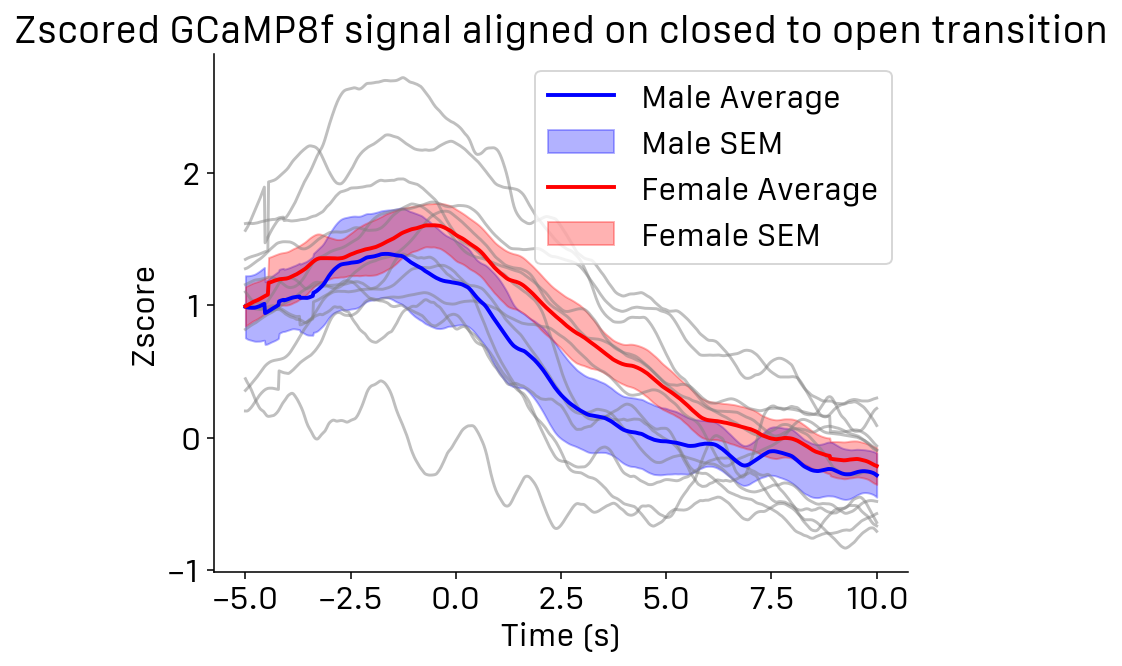

In [538]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_peth(df):
    # List to store the PETH for each mouse, separately for males and females
    male_average = []
    female_average = []
    
    # Loop through each mouse
    for mouse in df['ID'].unique():
        # Filter the data for the current mouse
        mouse_data = df[df['ID'] == mouse]
        
        # Group by 'time_vector' and calculate the mean Z-score for each time point
        zscore_grouped = mouse_data.groupby('time_vector')['Zscoreg'].mean()
        
        # Plot individual mouse PETH (gray trace)
        plt.plot(zscore_grouped.index, zscore_grouped, alpha=0.5, color='gray')
        
        # Append to the appropriate list based on sex
        if mouse_data['sex'].iloc[0] == 'M':  # If the mouse is male
            male_average.append(zscore_grouped)
        else:  # If the mouse is female
            female_average.append(zscore_grouped)
    
    # Convert list of individual averages into DataFrames
    male_average_df = pd.DataFrame(male_average)
    female_average_df = pd.DataFrame(female_average)
    
    # Calculate the mean and SEM across all males
    mean_males = male_average_df.mean(axis=0)
    sem_males = male_average_df.sem(axis=0)
    
    # Calculate the mean and SEM across all females
    mean_females = female_average_df.mean(axis=0)
    sem_females = female_average_df.sem(axis=0)
    
    # Plot the mean PETH for males and females with SEM
    plt.plot(mean_males.index, mean_males, color='blue', linewidth=2, label='Male Average')
    plt.fill_between(mean_males.index, mean_males - sem_males, 
                     mean_males + sem_males, color='blue', alpha=0.3, label='Male SEM')
    
    plt.plot(mean_females.index, mean_females, color='red', linewidth=2, label='Female Average')
    plt.fill_between(mean_females.index, mean_females - sem_females, 
                     mean_females + sem_females, color='red', alpha=0.3, label='Female SEM')
    
    # Add labels and title
    plt.xlabel('Time (s)')
    plt.ylabel('Zscore')
    plt.title('Zscored GCaMP8f signal aligned on closed to open transition')
    
    # Show the plot
    plt.legend()
    plt.show()

    return male_average_df, female_average_df

# Example usage:
# Call the function to plot PETH for each mouse and the average across all mice, separated by sex
male_avg_df, female_avg_df = plot_peth(df)


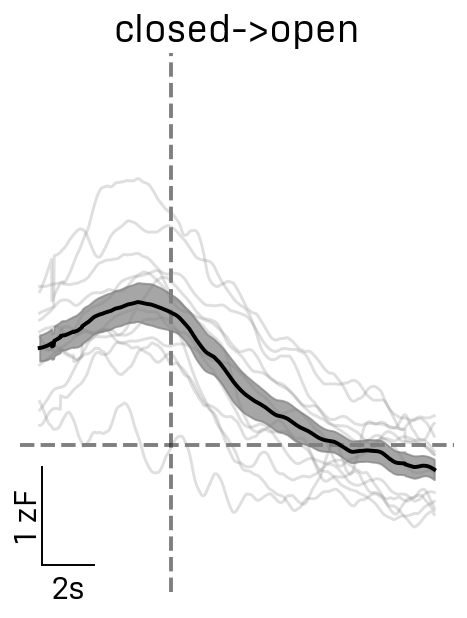

time_vector,-5.000000,-4.983333,-4.966667,-4.950000,-4.933333,-4.916667,-4.900000,-4.883333,-4.866667,-4.850000,...,9.850000,9.866667,9.883333,9.900000,9.916667,9.933333,9.950000,9.966667,9.983333,10.000000
Zscoreg,0.445884,0.434741,0.424489,0.414835,0.405637,0.396720,0.387688,0.377979,0.367112,0.354906,...,0.159634,0.168754,0.177584,0.186079,0.194177,0.201646,0.208146,0.213532,0.217993,0.221683
Zscoreg,1.618475,1.619559,1.620508,1.621226,1.621524,1.621278,1.620591,1.619747,1.619022,1.618573,...,-0.600205,-0.598046,-0.595260,-0.592009,-0.588490,-0.584912,-0.581517,-0.578494,-0.575911,-0.573688
Zscoreg,1.157461,1.160237,1.162871,1.165363,1.167784,1.170219,1.172717,1.175286,1.177904,1.180542,...,0.283114,0.285369,0.287802,0.290095,0.292041,0.293662,0.295135,0.296644,0.298265,0.299973
Zscoreg,0.999634,0.999826,1.000637,1.001506,1.002107,1.002358,1.002431,1.002569,1.002792,1.002851,...,-0.623201,-0.630544,-0.637502,-0.643949,-0.649497,-0.653732,-0.656750,-0.659387,-0.662508,-0.666032
Zscoreg,1.347716,1.350765,1.353646,1.356340,1.358850,1.361178,1.363336,1.365339,1.367186,1.368879,...,-0.257851,-0.258761,-0.260323,-0.262368,-0.264557,-0.266687,-0.268866,-0.271352,-0.274263,-0.277546
Zscoreg,1.003483,1.000529,0.997644,0.994881,0.992316,0.989966,0.987775,0.985711,0.983804,0.982050,...,-0.052268,-0.056753,-0.061417,-0.066159,-0.070898,-0.075577,-0.080165,-0.084646,-0.088999,-0.093230
Zscoreg,0.357446,0.362913,0.368375,0.373857,0.379438,0.385225,0.391307,0.397690,0.404282,0.410911,...,-0.475114,-0.475007,-0.475177,-0.475621,-0.476331,-0.477260,-0.478335,-0.479462,-0.480522,-0.481394
Zscoreg,1.566442,1.574851,1.583675,1.593001,1.602862,1.613371,1.624659,1.636668,1.649063,1.661417,...,0.168103,0.160495,0.152677,0.144820,0.136907,0.128704,0.120021,0.110914,0.101618,0.092339
Zscoreg,1.101556,1.094929,1.088246,1.081170,1.073667,1.066132,1.059012,1.052470,1.046503,1.041190,...,-0.682403,-0.681557,-0.681197,-0.681459,-0.682823,-0.685706,-0.690073,-0.695450,-0.701280,-0.707253
Zscoreg,0.202104,0.201772,0.201809,0.203075,0.206020,0.210389,0.215571,0.221152,0.227114,0.233675,...,-0.551089,-0.560657,-0.570319,-0.579973,-0.589681,-0.599600,-0.609781,-0.620106,-0.630398,-0.640491


In [539]:

def plot_peth(df):

    plt.figure(figsize=(4,5))
    # List to store the PETH for each mouse
    mouse_average = []
    
    # Loop through each mouse
    for mouse in df['ID'].unique():
        # Filter the data for the current mouse
        mouse_data = df[df['ID'] == mouse]
        
        # Group by 'time_vector' and calculate the mean Z-score for each time point
        zscore_grouped = mouse_data.groupby('time_vector')['Zscoreg'].mean()
        
        # Plot individual mouse PETH (gray trace)
        plt.plot(zscore_grouped.index, zscore_grouped, alpha=0.25, color='gray')
        
        # Append to the list of mouse averages
        mouse_average.append(zscore_grouped)
    
    # Convert list of individual averages into a DataFrame
    mouse_average_df = pd.DataFrame(mouse_average)
    
    # Calculate the mean and SEM across all mice
    mean_across_mice = mouse_average_df.mean(axis=0)
    sem_across_mice = mouse_average_df.sem(axis=0)
    

    # Plot the mean across all mice with SEM
    plt.plot(mean_across_mice.index, mean_across_mice, color='black', linewidth=2, label='Mean Across Mice')
    plt.fill_between(mean_across_mice.index, mean_across_mice - sem_across_mice, 
                     mean_across_mice + sem_across_mice, color='gray', alpha=0.7, label='SEM')
    
    plt.axvline(x=0, color='black', linestyle='--', linewidth=2, zorder=0, alpha=0.5)
    plt.axhline(y=0, color='black', linestyle='--', linewidth=2, zorder=0, alpha=0.5)
    
    # Add labels and title
    plt.xlabel('Time (s)')
    plt.ylabel('Zscore')
    plt.title('closed->open')


    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)


    #drop the y axis
    plt.gca().yaxis.set_visible(False)
    plt.gca().xaxis.set_visible(False)

    plt.ylim(-1.5, 4)
    y_min, y_max = plt.gca().get_ylim()  # Get current y-axis limits
    x_min, x_max = plt.gca().get_xlim()  # Get current x-axis limits
    scale_x_pos = x_min + (x_max - x_min) * 0.05  # Position to the left of the plot
    scale_y_pos = y_min + (y_max - y_min) * 0.05  # Position near the bottom of the plot

    plt.plot([scale_x_pos, scale_x_pos], [scale_y_pos, scale_y_pos + 1], color='black', linewidth=1)
    plt.text(scale_x_pos - 0.5, scale_y_pos + 0.5, '1 zF', ha='center', va='center', rotation='vertical')

    plt.plot([scale_x_pos, scale_x_pos + 2], [scale_y_pos, scale_y_pos], color='black', linewidth=1)  # Horizontal line at y=0
    plt.text(scale_x_pos + 1, scale_y_pos - 0.1, '2s', ha='center', va='top')

    
    # Show the plot
    # plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/EPM_FP/EPM_BLA/figures/opentoclosed.pdf', format='pdf')
    plt.show()

    return mouse_average_df

# Example usage:
# Call the function to plot PETH for each mouse and the average across all mice
plot_peth(df)


In [540]:

# # Iterate through each mouse
# for mouse, mouse_df in df.groupby('ID'):
#     # Iterate through each explorationnumber for the current mouse
#     for exploration, group in mouse_df.groupby('explorationnumber'):
#         # Skip exploration numbers with no data (e.g., explorationnumber == 0)
#         if exploration == 0:
#             continue
        
#         # Plot Zscoreg vs time_vector
#         plt.figure(figsize=(8, 5))
#         plt.plot(group['time_vector'], group['Zscoreg'], label=f"Exploration {exploration}")
        
#         # Add plot details
#         plt.title(f"Mouse: {mouse} | Exploration: {exploration}")
#         plt.xlabel('Time (s)')
#         plt.ylabel('Z-score (Zscoreg)')
#         plt.axvline(0, color='red', linestyle='--', label='Tone Onset')  # Indicate tone onset
#         plt.legend()
#         plt.grid()

#         # Show plot
#         plt.show()


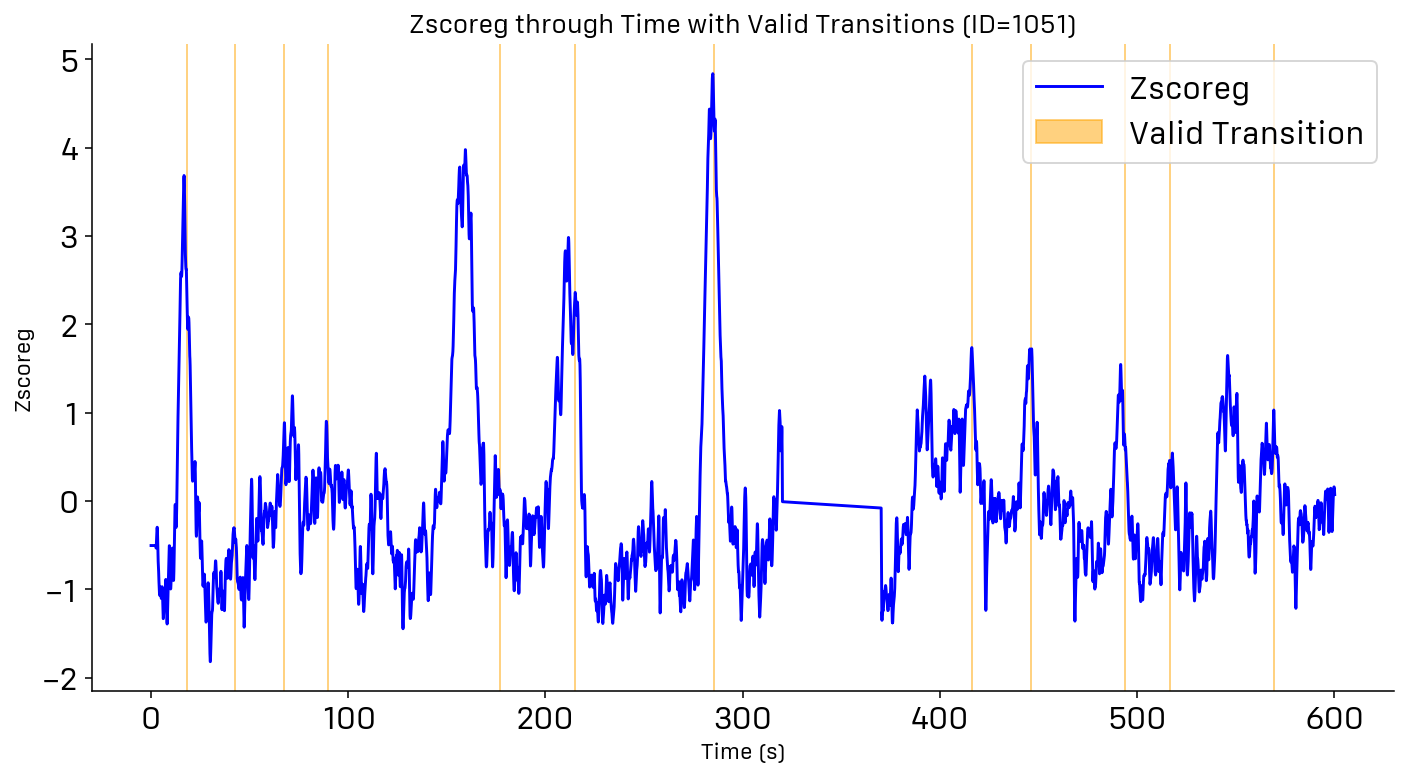

In [541]:

# Filter the DataFrame for ID=1051
df_1051 = df[df['ID'] == 1050]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Zscoreg through Time
plt.plot(df_1051['Time'], df_1051['Zscoreg'], label='Zscoreg', color='blue', linewidth=1.5)

# Highlight valid transitions as bars
for _, row in df_1051[df_1051['valid_transition'] == 1].iterrows():
    plt.axvspan(row['Time'], row['Time'], color='orange', alpha=0.5, label='Valid Transition')

# Add labels and title
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Zscoreg', fontsize=12)
plt.title('Zscoreg through Time with Valid Transitions (ID=1051)', fontsize=14)

# Add a legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels
plt.legend(by_label.values(), by_label.keys())

# Display the plot
plt.show()


In [542]:

# # Set the minimum event duration in seconds (e.g., 10 seconds)
# min_duration = 10

# # Create a boolean mask where 'In middle' is 1 (event occurs)
# event_mask = df['In middle'] == 1

# # Identify the indices where the event starts (transition from 0 to 1)
# start_indices = event_mask[(event_mask.shift(1) == 0) & (event_mask == 1)].index

# # Identify the indices where the event ends (transition from 1 to 0)
# end_indices = event_mask[(event_mask.shift(-1) == 0) & (event_mask == 1)].index

# # Ensure we have matching start and end indices
# if len(start_indices) != len(end_indices):
#     raise ValueError("Mismatch between start and end events")

# # Create a new column 'longmiddle' to store the result
# df['longmiddle'] = 0  # Default value is 0, meaning the event is not long enough

# # For each event, check the duration and recode 'longmiddle' as 1 if duration > min_duration
# for start, end in zip(start_indices, end_indices):
#     event_duration = df.loc[end, 'Time'] - df.loc[start, 'Time']
    
#     # If event duration is more than the threshold, set 'longmiddle' to 1
#     if event_duration >= min_duration:
#         df.loc[start:end, 'longmiddle'] = 1

# # Display the updated DataFrame
# print(df)
